In [1]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from io import StringIO
%matplotlib inline
from functools import reduce
import numpy as np

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [2]:
#get geojson from nashville.gov
crime_endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.geojson'
#params to select for aggravated burglary and dates
crime_params = {
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$where': 'incident_reported between \'2021-01-01\' and\'2021-06-30\'',
    '$limit': 2000
}
crime_response = requests.get(crime_endpoint, params = crime_params)

#convert dictionary to text and convert to dataframe with geopandas
crime = (gpd.read_file(StringIO(crime_response.text)))

#drop duplicates to prevent double counting incidents with multiple victims
crime = crime.drop_duplicates(subset = 'incident_number')

2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [3]:
#download census tract file and place in data folder. Read the .shp in with Geopandas and assign to census_tract
census_tract = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')

#Clean up the data set to make merging for part 3 easier. 
census_tract = census_tract[census_tract['COUNTYFP']== '037']
census_tract = census_tract.rename(columns = {'TRACTCE': 'tract'})
census_tract = census_tract.to_crs('epsg:4326')

#convert from geoseries to geodataframe and change crs type to match crime GeoDataFrame 'EPSG:4326'
#census_tract = gpd.GeoDataFrame(census_tract, 
#                           crs = crime.crs, 
#                           geometry = crime['geometry'])

#confirm identical crs type
print(census_tract.crs)
print(crime.crs)
print(type(crime))
print(type(census_tract))

epsg:4326
epsg:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [4]:
#join crime with census_tract
#changed how = 'right' to retain polygon geometry instead of point geometry. 
crime_census_tract = gpd.sjoin(crime, census_tract, how = 'right', op = 'within')
crime_census_tract = crime_census_tract[['incident_number','incident_reported', 'geometry', 'tract']]

#Find the census tract with the largest number of aggravated burglaries
crime_census_tract.groupby('tract')['incident_number'].nunique().nlargest(n=1)

tract
016300    53
Name: incident_number, dtype: int64

In [5]:
crime_census_tract.columns

Index(['incident_number', 'incident_reported', 'geometry', 'tract'], dtype='object')

3. For this part, you'll need to request a [census API key](https://api.census.gov/data/key_signup.html). Using the [2019 American Community Survey API](https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [6]:
#get API key
with open('../data/jg_census_API_key.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

In [7]:
#set up endpoint and params for population dataset
pop_endpoint = 'https://api.census.gov/data/2019/acs/acs5'
pop_params = {
    'get': 'B01001_001E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
pop_response = requests.get(pop_endpoint, params = pop_params)
              

In [8]:
#convert pop_response to json
pop_response = pop_response.json()
#create the dataframe and simplify the name.
pop = pd.DataFrame(data = pop_response[1:], columns = pop_response[0])
#convert population column to int and rename to something that at least looks like "population"
pop['B01001_001E'] = pop['B01001_001E'].astype(int)
pop = pop.rename(columns = {'B01001_001E': 'population'})

In [9]:
#set up endpoint and params for median income dataset 
income_endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
income_params = {
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
income_response = requests.get(income_endpoint, params = income_params)

In [10]:
income_response = income_response.json()
inc = pd.DataFrame(data = income_response[1:], columns = income_response[0])

#convert median income column to int
inc['S1901_C01_012E'] = inc['S1901_C01_012E'].astype(int)

#rename alphabet soup to something recognizable
inc = inc.rename(columns = {'S1901_C01_012E': 'Median Income'})

#Some median income values are extremely negative, which is impossible. Replace with NaN
inc['Median Income'] = inc['Median Income'].replace(-666666666, np.nan)

In [11]:
inc.sort_values(by="Median Income", ascending = False)


,Median Income,state,county,tract
39,193542.0,47,037,018203
42,190375.0,47,037,018601
21,188375.0,47,037,018602
140,183750.0,47,037,018700
139,167738.0,47,037,018500
...,...,...,...,...
69,14277.0,47,037,019300
37,NaN,47,037,013602
73,NaN,47,037,980100
74,NaN,47,037,980200


In [12]:
#https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes
#join the crime_census_tract geodataframe with the pop and inc dataframes.
data = [crime_census_tract, pop, inc]
crime_pop_inc = reduce(lambda left, right: pd.merge(left, right), data)

In [13]:
crime_pop_inc.head()

,incident_number,incident_reported,geometry,tract,population,state,county,Median Income
0,20210193617,2021-04-06T12:03:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
1,20210193565,2021-04-06T11:41:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
2,20210270239,2021-05-15T12:07:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
3,20210001419,2021-01-03T14:41:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
4,20210042105,2021-01-22T10:58:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0


In [14]:
census_tract.head()

,STATEFP,COUNTYFP,tract,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
27,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,+36.2610013,-086.8023491,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418,61097,+36.3444054,-086.8608396,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,47,037,010202,47037010202,102.02,Census Tract 102.02,G5020,S,68394934,77571,+36.3619781,-086.7746355,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,47,037,010104,47037010104,101.04,Census Tract 101.04,G5020,S,65057846,251504,+36.2918321,-086.8763469,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,47,037,013300,47037013300,133,Census Tract 133,G5020,S,2764220,0,+36.1597942,-086.8530466,"POLYGON ((-86.86843 36.16435, -86.86836 36.164..."


4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [29]:
#merge census_tract (polygon) with crime_pop_inc, create a new column for incident rate by dividing the incident number by the population
#create a new column for incidents per 1000 residents by multiplying incident rate by 1000
crime_pop_inc_by_census_tract = gpd.sjoin(crime_pop_inc, census_tract, op = 'within' )

crime_pop_inc_by_census_tract = crime_pop_inc_by_census_tract[['incident_number', 'geometry', 'tract_left','population','Median Income']]

crime_pop_inc_by_census_tract = crime_pop_inc_by_census_tract.rename(columns = {'tract_left': 'tract'})

crime_pop_inc_by_census_tract = crime_pop_inc_by_census_tract.groupby(by = ['tract', 'population', 'Median Income'],
                                                as_index = False)['incident_number'].nunique()
crime_pop_inc_by_census_tract['incident_rate'] = crime_pop_inc_by_census_tract['incident_number']/crime_pop_inc_by_census_tract['population']

crime_pop_inc_by_census_tract['incident_per_1000'] = crime_pop_inc_by_census_tract['incident_rate']*1000

In [27]:
#creating the 
crime_pop_inc_by_census_tract.head()

,tract,population,Median Income,incident_number,incident_rate,incident_per_1000
0,010103,2533,70341.0,0,0.000000,0.000000
1,010104,2955,64844.0,5,0.001692,1.692047
2,010105,4435,64688.0,3,0.000676,0.676437
3,010106,3397,63864.0,7,0.002061,2.060642
4,010201,4157,62829.0,4,0.000962,0.962232


In [33]:
choropleth_data = pd.merge(left = census_tract, right = crime_pop_inc_by_census_tract,  how = 'left' )
choropleth_data.head()



,STATEFP,COUNTYFP,tract,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,population,Median Income,incident_number,incident_rate,incident_per_1000
0,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,+36.2610013,-086.8023491,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",3397.0,63864.0,7.0,0.002061,2.060642
1,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418,61097,+36.3444054,-086.8608396,"POLYGON ((-86.91752 36.33976, -86.91747 36.339...",2533.0,70341.0,0.0,0.000000,0.000000
2,47,037,010202,47037010202,102.02,Census Tract 102.02,G5020,S,68394934,77571,+36.3619781,-086.7746355,"POLYGON ((-86.82482 36.33225, -86.82480 36.332...",3962.0,78750.0,0.0,0.000000,0.000000
3,47,037,010104,47037010104,101.04,Census Tract 101.04,G5020,S,65057846,251504,+36.2918321,-086.8763469,"POLYGON ((-86.97440 36.24991, -86.97244 36.252...",2955.0,64844.0,5.0,0.001692,1.692047
4,47,037,013300,47037013300,133,Census Tract 133,G5020,S,2764220,0,+36.1597942,-086.8530466,"POLYGON ((-86.86843 36.16435, -86.86836 36.164...",3997.0,69006.0,12.0,0.003002,3.002252


In [55]:
(choropleth_data['incident_per_1000']==0).sum()

12

In [65]:
choropleth_data['incident_per_1000'].isna().sum()

4

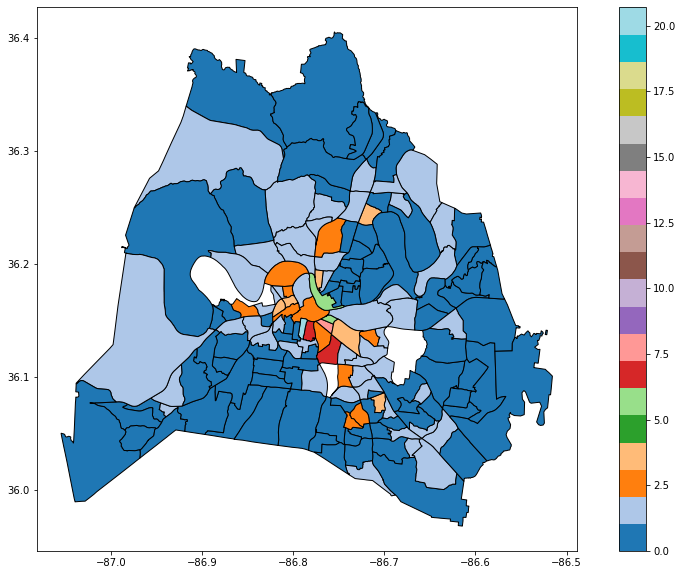

In [66]:
choropleth_data.plot(column = 'incident_per_1000',figsize = (15,10),
                    cmap = 'tab20',
                    edgecolor='black',
                    legend = True);

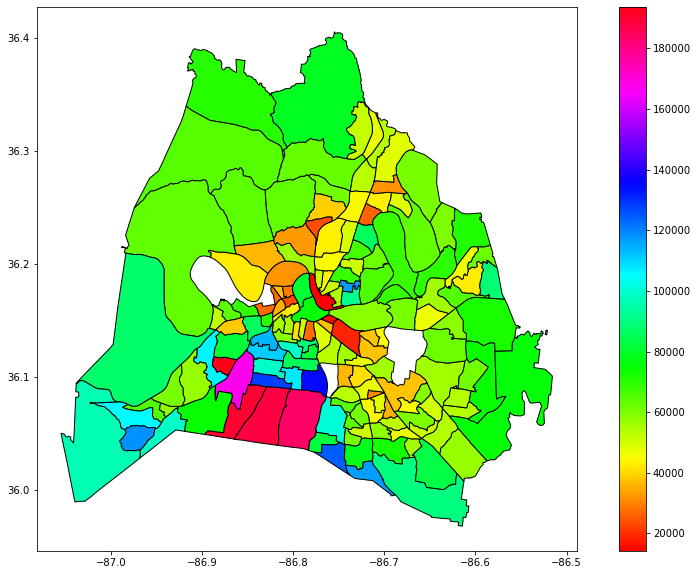

In [51]:
#not a part of the read.me but thought it would be cool to map median income too. 
choropleth_data.plot(column = 'Median Income',figsize = (15,10),
                    cmap = 'hsv',
                    edgecolor='black',
                    legend = True);

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the [Generalized Linear Models](https://www.statsmodels.org/stable/glm.html) module of the statsmodels library.

    a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

    b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

    c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out [this tutorial](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).

    d. How do your models compare? Hint: the fit models have an AIC attribute.